In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import mstats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score, precision_score,roc_auc_score,f1_score,confusion_matrix

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

import warnings
warnings.filterwarnings('ignore')


## 0.파일 불러오기

In [2]:
df = pd.read_csv('../data/processed_data/재무비율_재무지표_concat.csv', index_col=0)
df.head()

,회사명,거래소코드,회계년도,소속코드_df1,통계청 한국표준산업분류 코드 10차(대분류)_df1,산업코드_df1,산업명_df1,상장일_df1,상장폐지일_df1,현금및현금성자산(IFRS),...,자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS),label_df2
0,(주)다이나믹디자인,145210,2015,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,10376890.0,...,29.18,2.06,1548.77,46876.84,3589.40,0.0,0.0,14203.75,150.0,1
1,(주)다이나믹디자인,145210,2016,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,15192647.0,...,0.00,0.00,-11379.61,0.00,0.00,0.0,0.0,0.00,134.0,1
2,(주)다이나믹디자인,145210,2017,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,6564156.0,...,-90.09,-161.93,-34429.26,39598.55,3990.88,0.0,0.0,11694.91,526.0,1
3,(주)대우건설,47040,2012,1,41,64101,종합 건설업,2001-03-23,0,388440274.0,...,40.72,12.78,227947.72,802635.00,94086.89,124047.0,54145.0,51212.00,5192.0,0
4,(주)대우건설,47040,2013,1,41,64101,종합 건설업,2001-03-23,0,409596263.0,...,-125.45,-177.13,-839724.66,913926.00,86015.38,123239.0,62921.0,59003.00,6382.0,0


In [3]:
X_data = df[df.columns[9:-1]]
y_data = df['label_df2']

## 윈저라이징 이전 데이터 확인

In [4]:
before_winsor_feature = X_data.copy()

In [5]:
X_data.columns

Index(['현금및현금성자산(IFRS)', '유동금융자산(IFRS)', '매출채권 및 기타유동채권(IFRS)',
       '상각후원가측정 유가증권(IFRS)', '매출채권(IFRS)', '미수금(IFRS)', '단기대여금(IFRS)',
       '선급금(IFRS)', '기타유동자산(IFRS)', '상품(IFRS)',
       ...
       '노동소득분배율(IFRS)', '자본분배율(IFRS)', '이윤분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '인건비(IFRS)(백만원)', '금융비용(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)', '감가상각비(IFRS)(백만원)', '종업원수(IFRS)'],
      dtype='object', length=194)

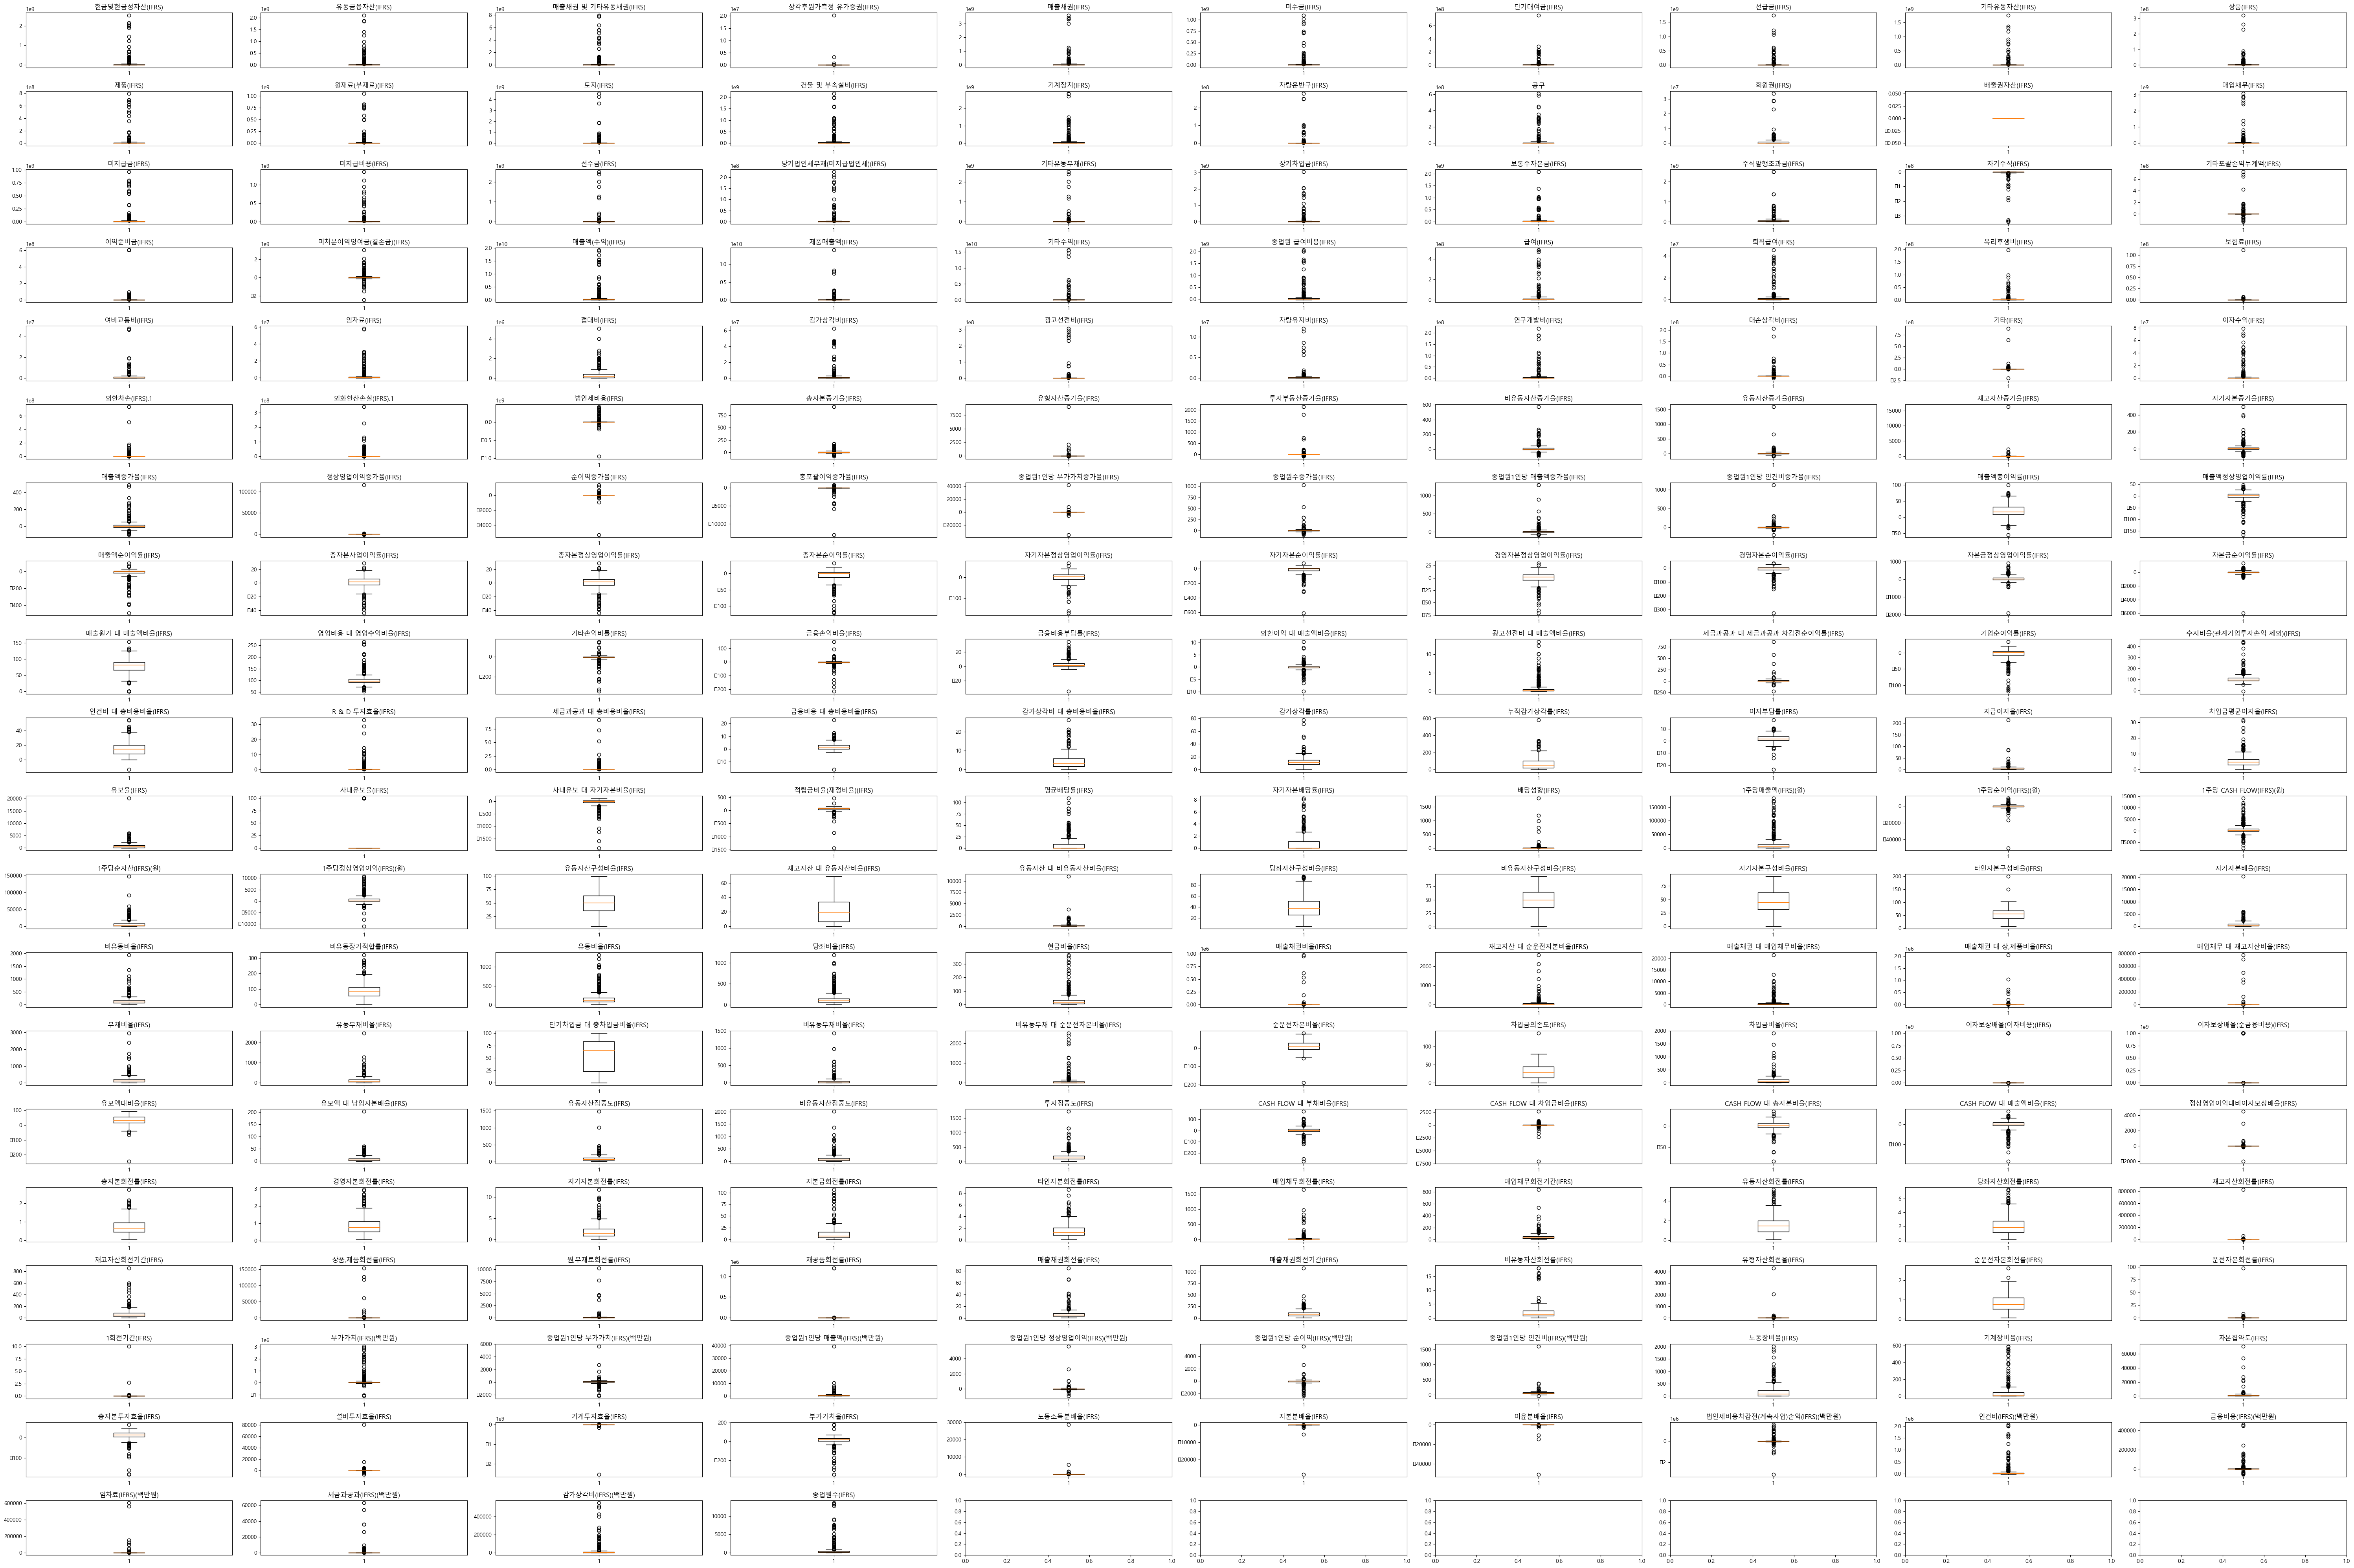

In [6]:
# from matplotlib import font_manager, rc
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'Malgun Gothic'

selected_variables = before_winsor_feature
# 5x4 subplot 생성
fig, axes = plt.subplots(20, 10, figsize=(60, 40))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

In [7]:
before_winsor_feature.describe()

,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.232927e+07,5.939977e+07,2.863112e+08,6.233210e+04,1.156015e+08,3.079093e+07,1.268258e+07,3.901258e+07,4.114176e+07,6.463591e+06,...,161.160154,-80.954499,-232.377558,1.559327e+04,9.478764e+04,9165.102982,5618.652057,832.450591,22192.300437,768.066838
std,2.911515e+08,2.210259e+08,1.025248e+09,1.042155e+06,4.057154e+08,1.250409e+08,5.284769e+07,1.551063e+08,1.747595e+08,2.641326e+07,...,1477.557172,1475.930332,2738.067051,2.784824e+05,2.875997e+05,45912.801525,43766.772036,5145.486096,65427.520577,1886.967186
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-28477.690000,-50846.420000,-3.124361e+06,-2.386364e+04,-54363.000000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,2.542381e+09,2.099634e+09,7.980449e+09,2.029100e+07,3.595024e+09,1.095078e+09,7.598982e+08,1.743728e+09,1.752561e+09,3.214640e+08,...,28577.690000,92.530000,77.600000,1.571030e+06,2.055868e+06,459499.000000,602155.270000,62921.000000,550894.000000,13602.000000


## 2. 이상치 처리
컬럼마다 이상치의 분포가 상하위, 상위, 하위에 분포하는 비율이 다르기 때문에 각자 다르게 이상치 조정 필요
- 상하위 고르게 분포한 컬럼
- 상위에 분포한 컬럼
- 하위에 분포한 컬럼


1%, 2%, 3%씩 처리 실시

In [8]:
# import numpy as np
# from scipy.stats import mstats
# import statsmodels.api as sm

# 중앙값과 절대 중앙값 편차 (MAD) 계산 함수
def mad_based_outliers(df, threshold=3):        # 임계값은 3으로 설정
    median = np.median(df)
    mad = sm.robust.scale.mad(df)
    mad_scaled = np.abs(df - median) / mad if mad != 0 else 0
    return mad_scaled > threshold

# 윈저라이징 조건 설정 함수
def apply_winsorization_based_on_outliers(df, threshold=3, pct = 0.01):
    df_winsor = df.copy()
    winsorization_info = {}  # 각 컬럼별 윈저라이징 방식을 저장할 딕셔너리

    for column in df_winsor.columns:
        # MAD 기반 이상치 탐지
        outliers_mask = mad_based_outliers(df_winsor[column], threshold)
        outliers_high = np.sum(outliers_mask & (df_winsor[column] > np.median(df_winsor[column])))
        outliers_low = np.sum(outliers_mask & (df_winsor[column] < np.median(df_winsor[column])))

        # 조건에 따라 윈저라이징 방식 결정
        if outliers_high > 0 and outliers_low == 0:  # 상위 이상치만 있을 때
            df_winsor[column] = mstats.winsorize(df_winsor[column], limits=(0, pct))  # 상위 2%만 윈저라이징
            winsorization_info[column] = f"상위 {pct*100}% 윈저라이징"
        elif outliers_low > 0 and outliers_high == 0:  # 하위 이상치만 있을 때
            df_winsor[column] = mstats.winsorize(df_winsor[column], limits=(pct, 0))  # 하위 2%만 윈저라이징
            winsorization_info[column] = f"하위 {pct*100}% 윈저라이징"
        elif outliers_high > 0 and outliers_low > 0:  # 상하위 이상치가 모두 있을 때
            df_winsor[column] = mstats.winsorize(df_winsor[column], limits=(pct, pct))  # 상하위 1%씩 윈저라이징
            winsorization_info[column] = f"상하위 {pct*100}% 윈저라이징"
    return df_winsor, winsorization_info

# 이상치처리 1%

In [9]:
X_data_winsor_1, winsorization_info_1 = apply_winsorization_based_on_outliers(X_data)

In [10]:
winsorization_info_1

{'현금및현금성자산(IFRS)': '상위 1.0% 윈저라이징',
 '유동금융자산(IFRS)': '상위 1.0% 윈저라이징',
 '매출채권 및 기타유동채권(IFRS)': '상위 1.0% 윈저라이징',
 '매출채권(IFRS)': '상위 1.0% 윈저라이징',
 '미수금(IFRS)': '상위 1.0% 윈저라이징',
 '단기대여금(IFRS)': '상위 1.0% 윈저라이징',
 '선급금(IFRS)': '상위 1.0% 윈저라이징',
 '기타유동자산(IFRS)': '상위 1.0% 윈저라이징',
 '상품(IFRS)': '상위 1.0% 윈저라이징',
 '제품(IFRS)': '상위 1.0% 윈저라이징',
 '원재료(부재료)(IFRS)': '상위 1.0% 윈저라이징',
 '토지(IFRS)': '상위 1.0% 윈저라이징',
 '건물 및 부속설비(IFRS)': '상위 1.0% 윈저라이징',
 '기계장치(IFRS)': '상위 1.0% 윈저라이징',
 '차량운반구(IFRS)': '상위 1.0% 윈저라이징',
 '공구': '상위 1.0% 윈저라이징',
 '회원권(IFRS)': '상위 1.0% 윈저라이징',
 '매입채무(IFRS)': '상위 1.0% 윈저라이징',
 '미지급금(IFRS)': '상위 1.0% 윈저라이징',
 '미지급비용(IFRS)': '상위 1.0% 윈저라이징',
 '선수금(IFRS)': '상위 1.0% 윈저라이징',
 '당기법인세부채(미지급법인세)(IFRS)': '상하위 1.0% 윈저라이징',
 '기타유동부채(IFRS)': '상위 1.0% 윈저라이징',
 '장기차입금(IFRS)': '상위 1.0% 윈저라이징',
 '보통주자본금(IFRS)': '상위 1.0% 윈저라이징',
 '주식발행초과금(IFRS)': '상위 1.0% 윈저라이징',
 '자기주식(IFRS)': '하위 1.0% 윈저라이징',
 '기타포괄손익누계액(IFRS)': '상하위 1.0% 윈저라이징',
 '이익준비금(IFRS)': '상위 1.0% 윈저라이징',
 '미처분이익잉여금(결손금)(IFRS)': '상하위 1.0% 

In [11]:
# 이상치 처리 전 후
display(before_winsor_feature.describe(), X_data_winsor_1.describe())

,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.232927e+07,5.939977e+07,2.863112e+08,6.233210e+04,1.156015e+08,3.079093e+07,1.268258e+07,3.901258e+07,4.114176e+07,6.463591e+06,...,161.160154,-80.954499,-232.377558,1.559327e+04,9.478764e+04,9165.102982,5618.652057,832.450591,22192.300437,768.066838
std,2.911515e+08,2.210259e+08,1.025248e+09,1.042155e+06,4.057154e+08,1.250409e+08,5.284769e+07,1.551063e+08,1.747595e+08,2.641326e+07,...,1477.557172,1475.930332,2738.067051,2.784824e+05,2.875997e+05,45912.801525,43766.772036,5145.486096,65427.520577,1886.967186
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-28477.690000,-50846.420000,-3.124361e+06,-2.386364e+04,-54363.000000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,2.542381e+09,2.099634e+09,7.980449e+09,2.029100e+07,3.595024e+09,1.095078e+09,7.598982e+08,1.743728e+09,1.752561e+09,3.214640e+08,...,28577.690000,92.530000,77.600000,1.571030e+06,2.055868e+06,459499.000000,602155.270000,62921.000000,550894.000000,13602.000000


,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.00000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.033575e+07,5.526025e+07,2.751007e+08,6.233210e+04,1.145453e+08,2.989942e+07,1.117425e+07,3.671834e+07,3.889997e+07,5.062943e+06,...,79.208946,0.99671,-58.395398,2.028244e+04,9.204095e+04,7631.461028,5618.652057,832.450591,21458.323213,763.552699
std,2.761684e+08,1.881681e+08,9.471311e+08,1.042155e+06,3.969903e+08,1.180894e+08,3.744812e+07,1.344437e+08,1.563627e+08,1.399248e+07,...,152.010418,146.81627,311.504058,2.256646e+05,2.703210e+05,31730.394902,43766.772036,5145.486096,60103.306478,1857.151766
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-1268.47000,-2833.890000,-1.010005e+06,-2.386364e+04,-41923.930000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.00000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.84000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.37000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,1.997405e+09,1.395762e+09,6.405704e+09,2.029100e+07,3.309701e+09,8.992580e+08,2.283170e+08,1.067214e+09,1.181187e+09,8.971500e+07,...,1368.470000,92.53000,77.600000,1.322484e+06,1.664754e+06,244876.000000,602155.270000,62921.000000,425846.620000,12781.000000


이상치 처리 후 시각화

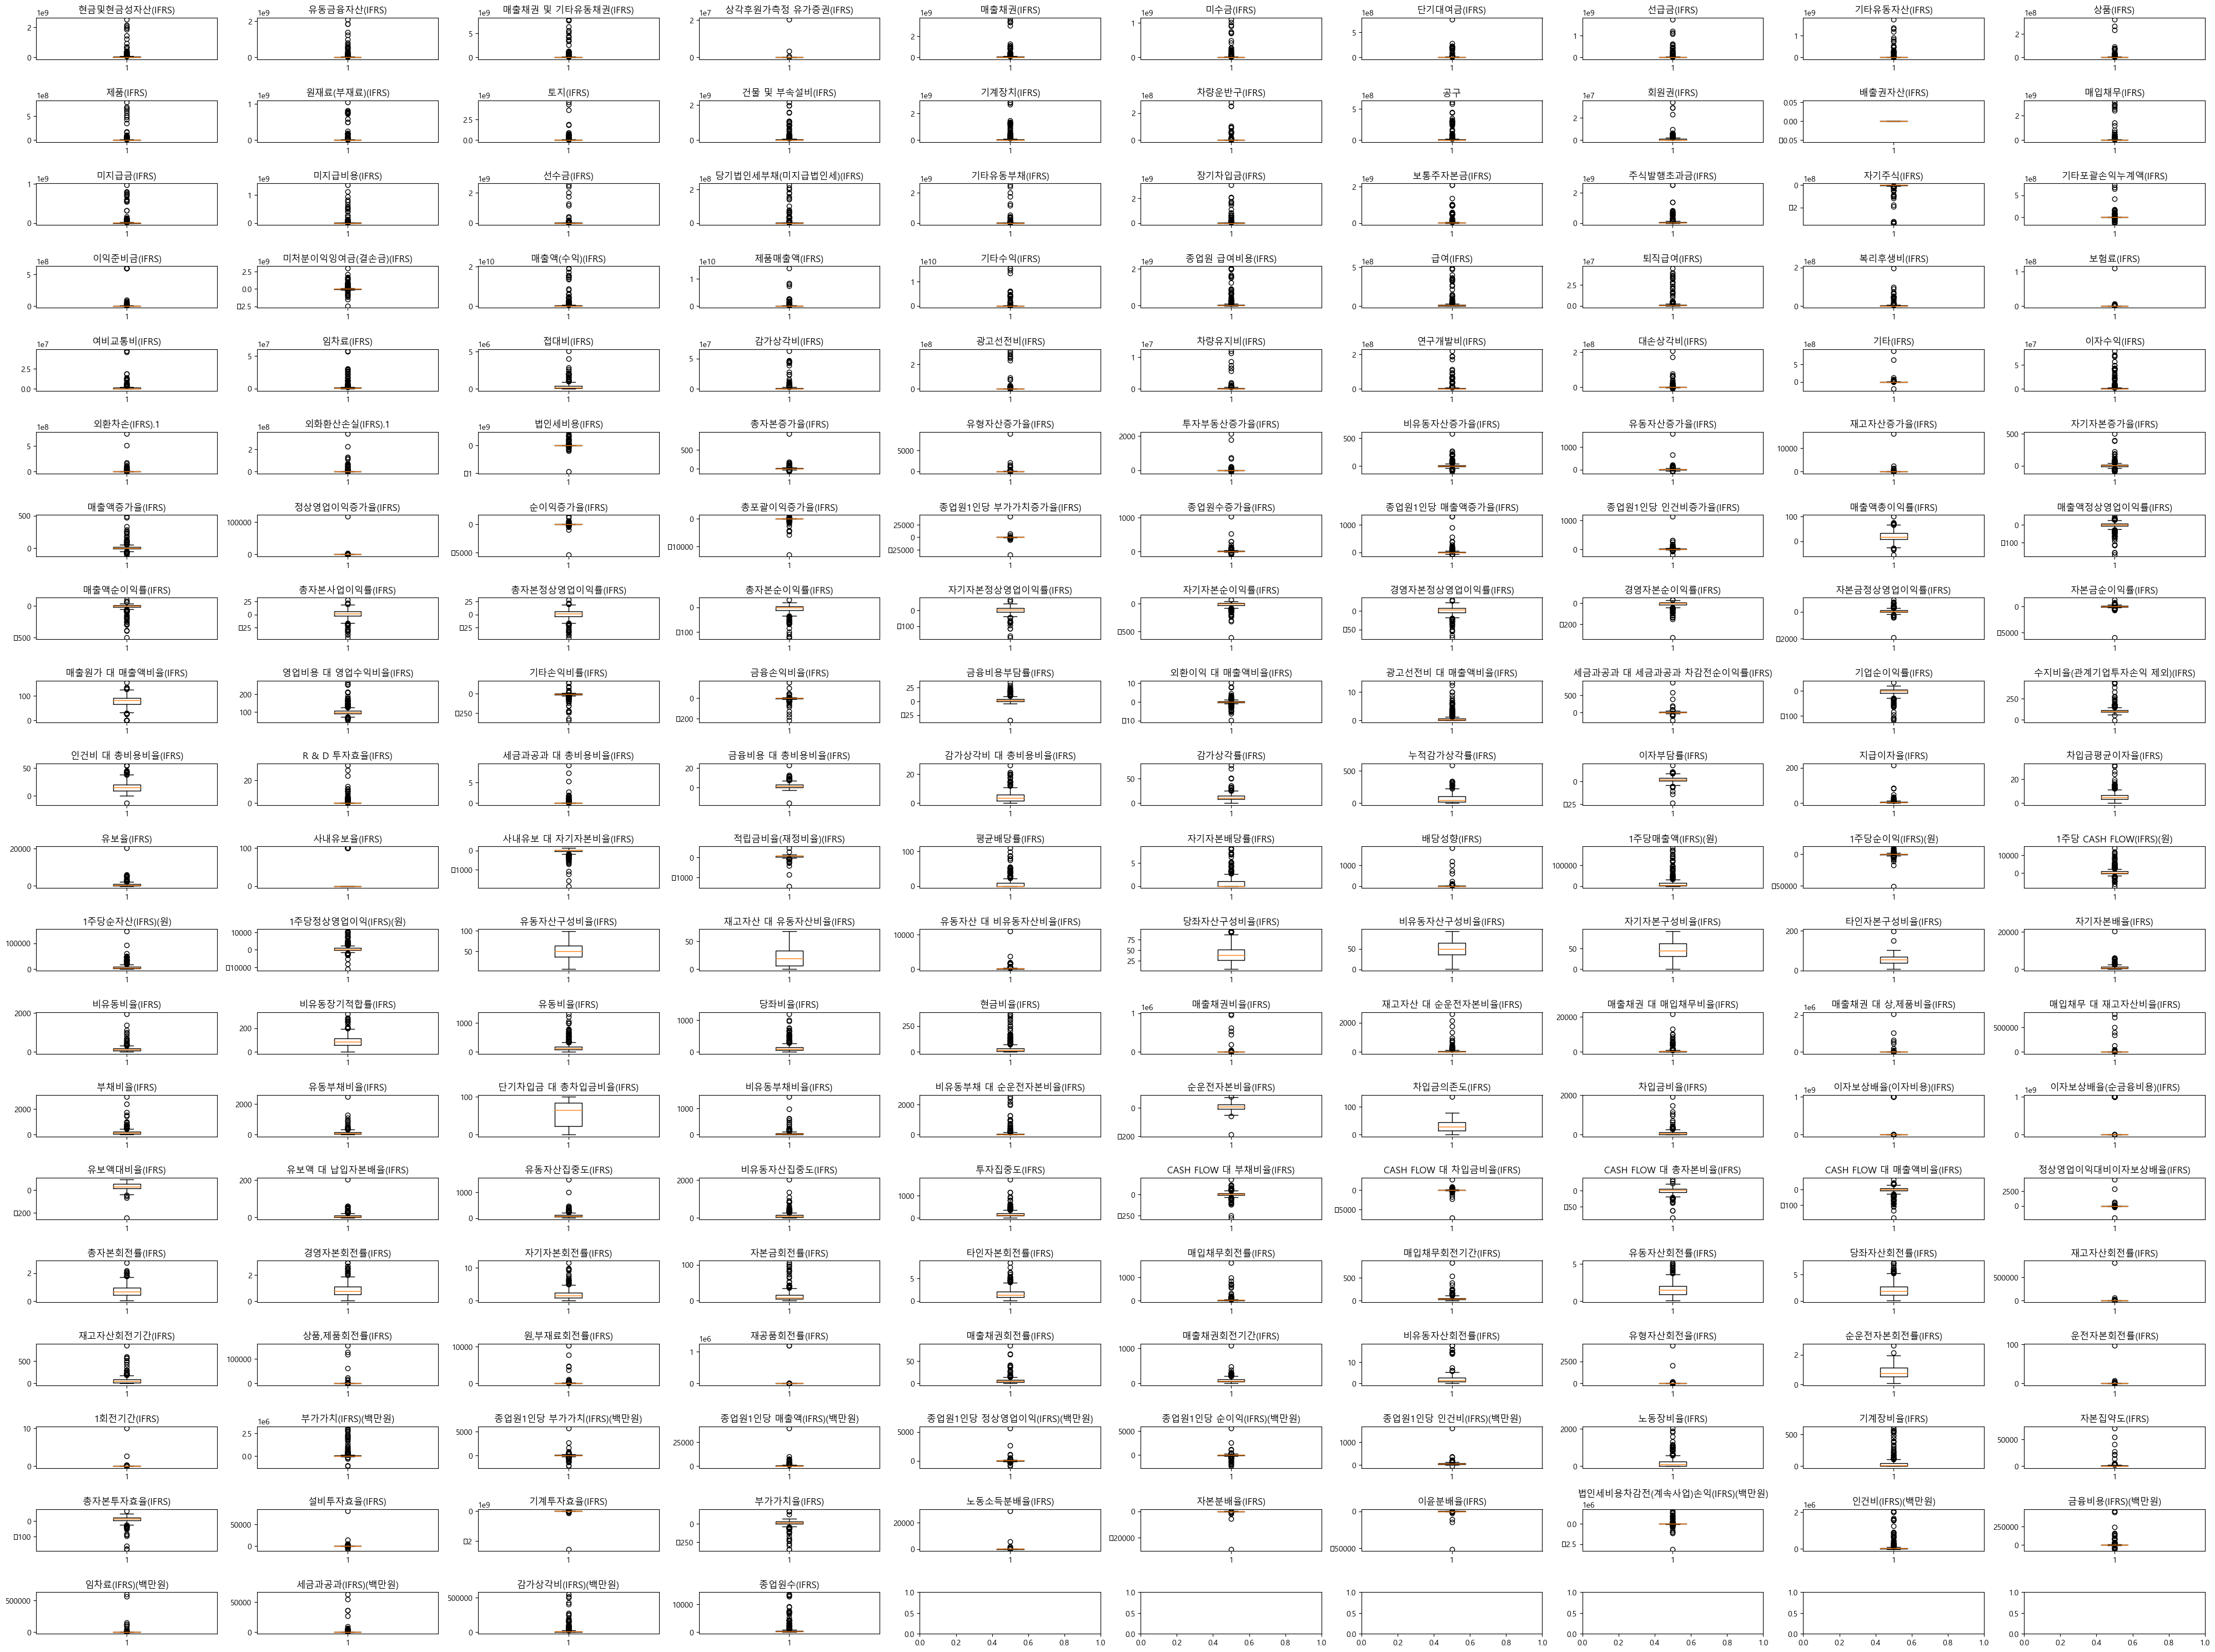

In [12]:
selected_variables = X_data_winsor_1
# 5x4 subplot 생성
fig, axes = plt.subplots(20, 10, figsize=(40, 30))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

## 1.로그변환 먼저

In [13]:
# 로그 변환할 컬럼들 지정
columns_to_log_transform = ['현금및현금성자산(IFRS)', '유동금융자산(IFRS)', '매출채권 및 기타유동채권(IFRS)',
       '상각후원가측정 유가증권(IFRS)', '매출채권(IFRS)', '미수금(IFRS)', '단기대여금(IFRS)',
       '선급금(IFRS)', '기타유동자산(IFRS)', '상품(IFRS)', '제품(IFRS)', '원재료(부재료)(IFRS)',
       '토지(IFRS)', '건물 및 부속설비(IFRS)', '기계장치(IFRS)', '차량운반구(IFRS)', '공구',
       '회원권(IFRS)', '배출권자산(IFRS)', '매입채무(IFRS)', '미지급금(IFRS)', '미지급비용(IFRS)',
       '선수금(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '기타유동부채(IFRS)', '장기차입금(IFRS)',
       '보통주자본금(IFRS)', '주식발행초과금(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '매출액(수익)(IFRS)', '제품매출액(IFRS)',
       '기타수익(IFRS)', '종업원 급여비용(IFRS)', '급여(IFRS)', '퇴직급여(IFRS)', '복리후생비(IFRS)',
       '보험료(IFRS)', '여비교통비(IFRS)', '임차료(IFRS)', '접대비(IFRS)', '감가상각비(IFRS)',
       '광고선전비(IFRS)', '차량유지비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)',
       '이자수익(IFRS)', '외환차손(IFRS).1', '외화환산손실(IFRS).1', '법인세비용(IFRS)','부가가치(IFRS)(백만원)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '인건비(IFRS)(백만원)', '금융비용(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)', '감가상각비(IFRS)(백만원)', '종업원수(IFRS)']

# 1. 로그 변환 적용
X_data_winsor_1[columns_to_log_transform] = np.sign(X_data_winsor_1[columns_to_log_transform]) * np.log(np.abs(X_data_winsor_1[columns_to_log_transform]) + 1)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_data_winsor_1,y_data,test_size=0.3,stratify=y_data,random_state = 40)

In [15]:
n, d = X_train.shape
print("number of feature:", d)
print("number of feature:", n)

number of feature: 194
number of feature: 272


## 2. 스케일링(생략)

## 3. Feature Selection

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
# 컬럼명 출력을 위한 옵션 설정
pd.set_option('display.max_columns', None)      # 모든 컬럼이 출력되도록 설정
# pd.set_option('display.max_colwidth', None)     # 컬럼 너비를 제한 없이 설정
pd.set_option('display.max_seq_items', None)

In [ ]:
# VIF 계산 및 다중공선성 제거 함수 정의
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def remove_multicollinearity(df, threshold=10):
    vif_data = calculate_vif(df)
    while vif_data['VIF'].max() > threshold:
        max_vif_feature = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Removing '{max_vif_feature}' with VIF: {vif_data['VIF'].max()}")
        df = df.drop(columns=[max_vif_feature])
        vif_data = calculate_vif(df)
    return df

# X = X_train.replace([np.inf, -np.inf], np.nan)  # inf를 NaN으로 변환
# X_train = X.fillna(0)

# 독립 변수에 대한 다중공선성 제거 수행
X_cleaned = remove_multicollinearity(X_train)

# 다중공선성 제거 후 라벨값과 결합
# X_123 = pd.concat([X_train, y_train], axis=1)


print("\n최종 데이터프레임:")
print(X_cleaned.columns)


Removing '영업비용 대 영업수익비율(IFRS)' with VIF: 1955356097.2114143
Removing '종업원 급여비용(IFRS)' with VIF: 73749915.65242437
Removing '매출액(수익)(IFRS)' with VIF: 188350.35774896987
Removing '타인자본구성비율(IFRS)' with VIF: 30994.129789897874
Removing '총자본순이익률(IFRS)' with VIF: 25195.597889469507
Removing '보통주자본금(IFRS)' with VIF: 21771.828024070743
Removing '급여(IFRS)' with VIF: 20339.85511719455
Removing '매출채권 및 기타유동채권(IFRS)' with VIF: 16310.694163125912
Removing '노동소득분배율(IFRS)' with VIF: 14109.83341756574
Removing '인건비(IFRS)(백만원)' with VIF: 13180.151105089912
Removing '유보율(IFRS)' with VIF: 6314.896373317905
Removing '총자본정상영업이익률(IFRS)' with VIF: 6250.1436885344165
Removing '유동자산구성비율(IFRS)' with VIF: 4253.387204181289
Removing '비유동자산구성비율(IFRS)' with VIF: 2764.4892547945055
Removing '감가상각비(IFRS)(백만원)' with VIF: 2545.6961168608723
Removing '부채비율(IFRS)' with VIF: 1691.8122419019826
Removing '매입채무(IFRS)' with VIF: 1059.088912533015
Removing '매출채권(IFRS)' with VIF: 915.3161422264648
Removing '유보액 대 납입자본배율(IFRS)' 

In [21]:
X_cleaned.columns

Index(['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '유동자산증가율(IFRS)', '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)', '매출액정상영업이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '자본금순이익률(IFRS)',
       '기타손익비률(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)',
       '감가상각비 대 총비용비율(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대

In [18]:
# 다중공선성 제거 후
['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '유동자산증가율(IFRS)', '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)', '매출액정상영업이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '자본금순이익률(IFRS)',
       '기타손익비률(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)',
       '감가상각비 대 총비용비율(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)',
       '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '순운전자본비율(IFRS)', '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)',
       '비유동자산집중도(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)', 'CASH FLOW 대 총자본비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자본금회전률(IFRS)',
       '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '재고자산회전기간(IFRS)',
       '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)', '매출채권회전률(IFRS)',
       '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)', '운전자본회전률(IFRS)', '1회전기간(IFRS)',
       '종업원1인당 매출액(IFRS)(백만원)', '종업원1인당 정상영업이익(IFRS)(백만원)',
       '종업원1인당 순이익(IFRS)(백만원)', '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']

['상각후원가측정 유가증권(IFRS)',
 '단기대여금(IFRS)',
 '상품(IFRS)',
 '회원권(IFRS)',
 '배출권자산(IFRS)',
 '당기법인세부채(미지급법인세)(IFRS)',
 '자기주식(IFRS)',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '제품매출액(IFRS)',
 '기타수익(IFRS)',
 '접대비(IFRS)',
 '연구개발비(IFRS)',
 '대손상각비(IFRS)',
 '기타(IFRS)',
 '외화환산손실(IFRS).1',
 '법인세비용(IFRS)',
 '유형자산증가율(IFRS)',
 '투자부동산증가율(IFRS)',
 '비유동자산증가율(IFRS)',
 '유동자산증가율(IFRS)',
 '재고자산증가율(IFRS)',
 '자기자본증가율(IFRS)',
 '매출액증가율(IFRS)',
 '정상영업이익증가율(IFRS)',
 '순이익증가율(IFRS)',
 '총포괄이익증가율(IFRS)',
 '종업원1인당 부가가치증가율(IFRS)',
 '종업원수증가율(IFRS)',
 '종업원1인당 매출액증가율(IFRS)',
 '종업원1인당 인건비증가율(IFRS)',
 '매출액총이익률(IFRS)',
 '매출액정상영업이익률(IFRS)',
 '자기자본정상영업이익률(IFRS)',
 '자본금정상영업이익률(IFRS)',
 '자본금순이익률(IFRS)',
 '기타손익비률(IFRS)',
 '금융손익비율(IFRS)',
 '외환이익 대 매출액비율(IFRS)',
 '광고선전비 대 매출액비율(IFRS)',
 '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
 'R & D 투자효율(IFRS)',
 '세금과공과 대 총비용비율(IFRS)',
 '금융비용 대 총비용비율(IFRS)',
 '감가상각비 대 총비용비율(IFRS)',
 '누적감가상각률(IFRS)',
 '지급이자율(IFRS)',
 '사내유보율(IFRS)',
 '사내유보 대 자기자본비율(IFRS)',
 '적립금비율(재정비율)(IFRS)',
 '평균배당률(IFRS)',
 

In [19]:
X_train = X_train[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '유동자산증가율(IFRS)', '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)', '매출액정상영업이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '자본금순이익률(IFRS)',
       '기타손익비률(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)',
       '감가상각비 대 총비용비율(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)',
       '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '순운전자본비율(IFRS)', '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)',
       '비유동자산집중도(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)', 'CASH FLOW 대 총자본비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자본금회전률(IFRS)',
       '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '재고자산회전기간(IFRS)',
       '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)', '매출채권회전률(IFRS)',
       '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)', '운전자본회전률(IFRS)', '1회전기간(IFRS)',
       '종업원1인당 매출액(IFRS)(백만원)', '종업원1인당 정상영업이익(IFRS)(백만원)',
       '종업원1인당 순이익(IFRS)(백만원)', '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]
X_test = X_test[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '유동자산증가율(IFRS)', '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)', '매출액정상영업이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '자본금순이익률(IFRS)',
       '기타손익비률(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)',
       '감가상각비 대 총비용비율(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)',
       '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '순운전자본비율(IFRS)', '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)',
       '비유동자산집중도(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)', 'CASH FLOW 대 총자본비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자본금회전률(IFRS)',
       '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '재고자산회전기간(IFRS)',
       '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)', '매출채권회전률(IFRS)',
       '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)', '운전자본회전률(IFRS)', '1회전기간(IFRS)',
       '종업원1인당 매출액(IFRS)(백만원)', '종업원1인당 정상영업이익(IFRS)(백만원)',
       '종업원1인당 순이익(IFRS)(백만원)', '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]

In [20]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind

# 예시 데이터 준비 (X: 특성, y: 타겟)
# X = 데이터프레임 (특성), y = 타겟 벡터

# 1. Lasso 회귀로 피쳐 선택
lasso = LassoCV(cv=5)  # 교차 검증을 사용하여 최적의 alpha를 선택
lasso.fit(X_train, y_train)

# 중요 피쳐 추출 (lasso.coef_는 선택된 피쳐들의 계수)
selected_features = X_train.columns[(lasso.coef_ != 0)]

# 2. 선택된 피쳐들에 대해 t-test 수행
p_values = []

for feature in selected_features:
    # 각 피쳐별로 t-test 수행 (클래스가 2개로 가정, y1과 y2를 기준으로)
    group1 = X_train[y_train == 0][feature]  # y == 0인 그룹의 데이터
    group2 = X_train[y_train == 1][feature]  # y == 1인 그룹의 데이터
    
    _, p_value = ttest_ind(group1, group2)
    p_values.append((feature, p_value))

# 3. p-value를 기준으로 피쳐 정렬
sorted_features = sorted(p_values, key=lambda x: x[1])

# p-value가 유효한 순서대로 출력
sorted_features_df = pd.DataFrame(sorted_features, columns=["Feature", "p-value"])

print(sorted_features_df)


               Feature   p-value
0  이자보상배율(순금융비용)(IFRS)  0.551658


In [21]:
list(sorted_features_df['Feature'])

['이자보상배율(순금융비용)(IFRS)']

## 4. Resampling(생략)

## 5. 모델링

Accuracy: 0.6410256410256411
Precision: 0.7473684210526316
Recall: 0.797752808988764
F1 Score: 0.7717391304347826


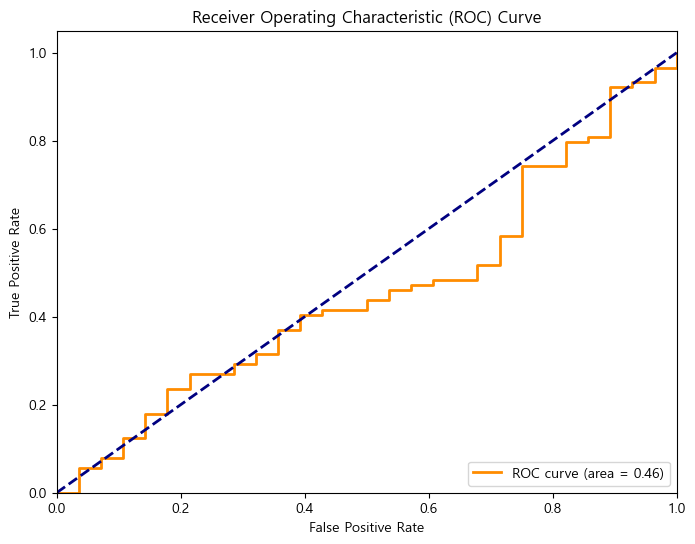

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 예시 데이터 (X_train, X_test, y_train, y_test가 있다고 가정)
# model 생성 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 평가 지표 계산
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC 커브 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [23]:
df2 = pd.DataFrame()

In [24]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred_train = logit.predict(X_train)
y_pred_test = logit.predict(X_test)

log_train = [accuracy_score(y_train, y_pred_train),precision_score(y_train, y_pred_train),recall_score(y_train, y_pred_train),f1_score(y_train, y_pred_train),roc_auc_score(y_train, y_pred_train)]
log_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['logit_train'] = log_train
df2['logit_test'] = log_test

print(confusion_matrix(y_test,y_pred_test))

[[ 4 24]
 [18 71]]


In [25]:
df2.index = ['accuracy','precision','recall','f1-score','roc-auc']
df2

,logit_train,logit_test
accuracy,0.628676,0.641026
precision,0.734513,0.747368
recall,0.801932,0.797753
f1-score,0.766744,0.771739
roc-auc,0.439428,0.470305
